In [1]:
import os
import sys
import logging
from gymnasium.wrappers import RescaleAction, ClipAction

# Setting path for all packages
os.environ["OMP_NUM_THREADS"] = "1"
# os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(
    os.path.join(
        "/Users/chatt07/Desktop/envs_10/contextual_env/Quantum_Optimal_Control"
    )
)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/chatt07/Desktop/envs_10/contextual_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Coupling map:


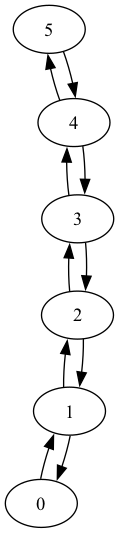

In [2]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "rx", "rx", "rx", "rx", "rx"]
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

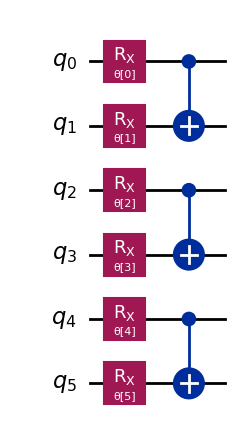

In [3]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 2.353304971691044, ParameterVectorElement(θ[1]): 5.9735141613602165, ParameterVectorElement(θ[2]): 4.599253580133889, ParameterVectorElement(θ[3]): 3.761482191925223, ParameterVectorElement(θ[4]): 0.980294029274052, ParameterVectorElement(θ[5]): 0.9801424781769557}


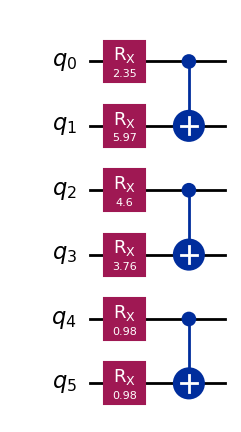

In [4]:
seed = 42
np.random.seed(seed)
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
# rotation_angles = np.array([0.0, 0.0, np.pi, 0., 0.0, 0.0])
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

Text(0.5, 1.0, 'Spillover rate matrix')

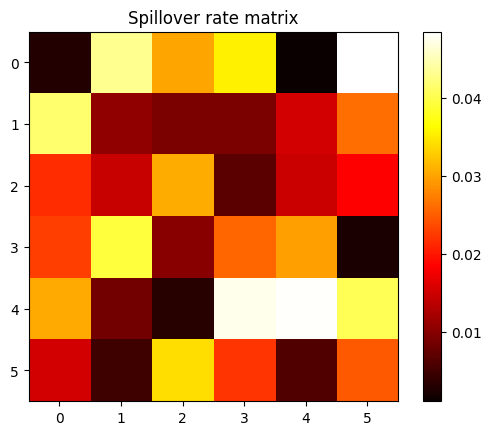

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.000  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.0  # γ_1->2
gamma_matrix[2, 2] = 0.1
gamma_matrix[2, 3] = 0.04  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.0  # γ_4->3
gamma_matrix[5, 4] = 0.0  # γ_5->4
gamma_matrix = 0.05 * np.round(np.random.rand(num_qubits, num_qubits), 3)
# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")

# Display gamma matrix as weights in a directed graph
# import networkx as nx
#
# G = nx.DiGraph(gamma_matrix)
# pos = nx.spring_layout(G)
# nx.draw(G, None, with_labels=True, node_size=1000, node_color="skyblue", font_size=10)
# labels = nx.get_edge_attributes(G, "weight")
# nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
# plt.title("Spillover rate matrix as directed graph")

In [6]:
gamma_matrix

array([[0.0029 , 0.0433 , 0.03005, 0.0354 , 0.00105, 0.0485 ],
       [0.0416 , 0.0106 , 0.0091 , 0.00915, 0.0152 , 0.02625],
       [0.0216 , 0.01455, 0.0306 , 0.00695, 0.0146 , 0.0183 ],
       [0.0228 , 0.03925, 0.01   , 0.0257 , 0.0296 , 0.0023 ],
       [0.0304 , 0.00855, 0.00325, 0.04745, 0.0483 , 0.0404 ],
       [0.01525, 0.0049 , 0.0342 , 0.022  , 0.0061 , 0.02475]])

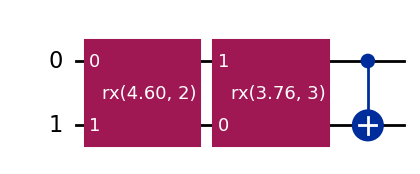

In [7]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [8]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [9]:
backend.operation_names

['measure',
 'roerror',
 'while_loop',
 'save_matrix_product_state',
 'for_loop',
 'save_amplitudes_sq',
 'ry',
 'break_loop',
 'save_probabilities_dict',
 's',
 'save_stabilizer',
 'save_amplitudes',
 'kraus',
 'save_statevector',
 'z',
 'save_unitary',
 'initialize',
 'save_density_matrix',
 'h',
 'unitary',
 'reset',
 'switch_case',
 'set_stabilizer',
 'u',
 'set_unitary',
 'save_state',
 'save_clifford',
 'quantum_channel',
 'continue_loop',
 'set_statevector',
 'superop',
 'save_expval_var',
 'set_matrix_product_state',
 'save_superop',
 'set_density_matrix',
 'set_superop',
 'save_statevector_dict',
 'cx',
 'qerror_loc',
 'rz',
 'save_expval',
 'save_probabilities',
 'delay',
 'rzx',
 'if_else',
 'rx',
 'x']

In [10]:
print("Rotation angles:", rotation_angles)

Rotation angles: [2.35330497 5.97351416 4.59925358 3.76148219 0.98029403 0.98014248]


In [11]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '14096d337fa94a8291acafd0c1f32636',
   'operations': ['rx(4.60, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.98557338+0.j        , 0.        -0.16924868j,
               0.        +0.j        , 0.        +0.j        ],
              [0.        -0.16924868j, 0.98557338+0.j        ,
               0.        +0.j        , 0.        +0.j        ],
              [0.        +0.j        , 0.        +0.j        ,
               0.98557338+0.j        , 0.        -0.16924868j],
              [0.        +0.j        , 0.        +0.j        ,
               0.        -0.16924868j, 0.98557338+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0, 1)]},
  {'type': 'qerror',
   'id': 'b17e3e1de1384e5bae970e98a2747535',
   'operations': ['rx(3.76, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0, 1],
      'params': [array([[0.9860315+0.j        , 0.       +0.j        ,
         

In [12]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[ 0.20313331+0.j        ,  0.        +0.22752042j,
            0.        +0.63426316j, -0.71040943+0.j        ],
          [-0.71040943+0.j        ,  0.        +0.63426316j,
            0.        +0.22752042j,  0.20313331+0.j        ],
          [ 0.        +0.63426316j, -0.71040943+0.j        ,
            0.20313331+0.j        ,  0.        +0.22752042j],
          [ 0.        +0.22752042j,  0.20313331+0.j        ,
           -0.71040943+0.j        ,  0.        +0.63426316j]],
         input_dims=(2, 2), output_dims=(2, 2))


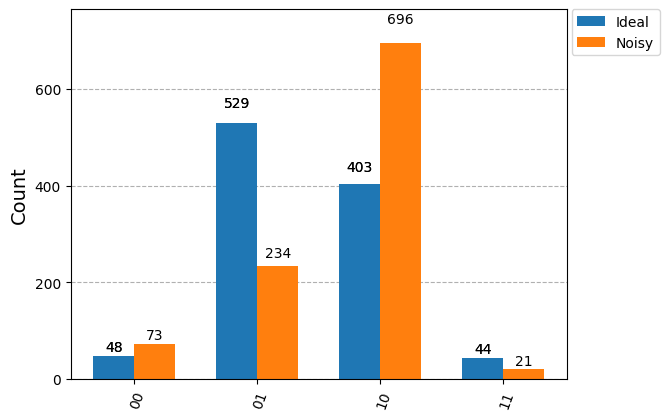

In [13]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [14]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [15]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.9123297060902809

In [16]:
from qiskit import QuantumRegister
from rl_qoc.helpers.circuit_utils import get_gate


# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))
    new_params = [optimal_params[i] + params[i] for i in range(len(params))]

    my_qc.u(
        *new_params[:3],
        q_reg[0],
    )
    my_qc.u(
        *new_params[3:6],
        q_reg[1],
    )

    my_qc.rzx(new_params[-1], q_reg[0], q_reg[1])

    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [17]:
# Define the environment
from gymnasium.spaces import Box
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    RescaleAndClipAction,
)
from rl_qoc.environment.configuration.backend_config import QiskitConfig

env_metadata = {
    "γ": gamma_matrix,
    "target_subsystem": (2, 3),
    "rotation_axes": rotation_axes,
    "num_qubits": num_qubits,
    "rotation_parameters": rotation_parameters,
    "seed": seed,
}
action_space = Box(low=-1.0, high=1.0, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
    pass_manager=None,
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=32, n_reps=[4, 7, 9, 12], n_shots=100, sampling_paulis=40, c_factor=1
    ),
    reward_config="cafe",
    env_metadata=env_metadata,
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)

In [18]:
rescaled_env = RescaleAndClipAction(q_env, -1, 1)

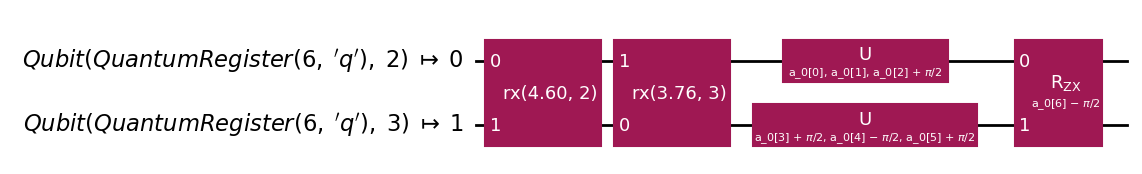

In [19]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [20]:
from rl_qoc.agent import PPOConfig

agent_config = PPOConfig.from_yaml("agent_config.yaml")
print(agent_config)

PPOConfig(run_name='spillover_subsystem', num_updates=1, n_epochs=8, learning_rate=0.0005, gamma=0.99, gae_lambda=0.95, clip_ratio=0.2, clip_value_loss=True, clip_value_coef=0.2, normalize_advantage=True, entropy_coef=0.01, value_loss_coef=0.5, gradient_clip=0.5, include_critic=True, hidden_layers=[64, 64], hidden_activation_functions=[Tanh(), Tanh()], input_activation_function=Identity(), output_activation_mean=Tanh(), output_activation_std=Sigmoid(), optimizer=<class 'torch.optim.adam.Adam'>, minibatch_size=16, checkpoint_dir='tmp/ppo', training_config=TrainingConfig(training_constraint=TotalUpdates(total_updates=250), target_fidelities=[0.999, 0.9999, 0.99999], lookback_window=10, anneal_learning_rate=False, std_actions_eps=0.01), train_function_settings=TrainFunctionSettings(plot_real_time=False, print_debug=False, num_prints=10, hpo_mode=False, clear_history=False, save_data=False), wandb_config=WandBConfig(enabled=True, project='GateCalibration', entity=None, tags=None, notes=Non

In [22]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env, save_data=False)
total_updates = 500
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = True

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=True,
)

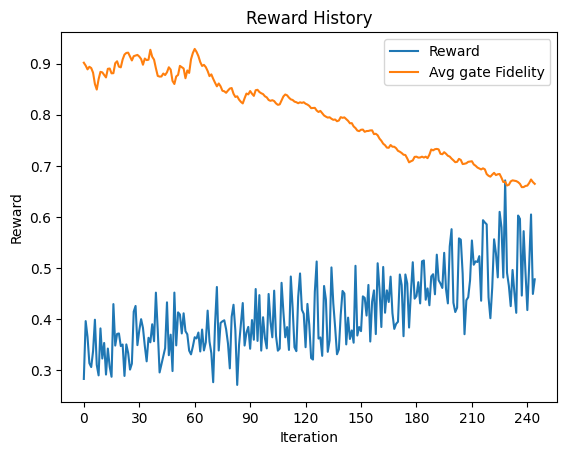


 Number of repetitions: 9
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.669269378768871
Sending Sampler job...
Time for running 1.625317096710205 seconds
Finished Sampler job
Reward (avg): 0.5605859375 Std: 0.21350045611938065

 Number of repetitions: 12
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.6671761710783188
Sending Sampler job...
Time for running 1.0267560482025146 seconds
Finished Sampler job
Reward (avg): 0.49447265625 Std: 0.188875883452535

 Number of repetitions: 7
Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.6686795882967195
Sending Sampler job...


{'avg_reward': [0.28244140624999997,
  0.39572265624999997,
  0.36496093749999997,
  0.31330078125,
  0.3056640625,
  0.33681640625,
  0.3984375,
  0.30982421875,
  0.28939453125,
  0.3814453125,
  0.3223828125,
  0.352890625,
  0.29097656250000004,
  0.341953125,
  0.306171875,
  0.28666015625,
  0.4290625,
  0.3478125,
  0.3705859375,
  0.37150390624999996,
  0.346796875,
  0.34986328125,
  0.28826171875,
  0.35003906250000005,
  0.33306640625,
  0.30068359375000003,
  0.31240234375,
  0.41431640625,
  0.42546875,
  0.34865234375,
  0.37734375,
  0.39955078125,
  0.3825,
  0.34697265624999996,
  0.31689453125,
  0.36306640625,
  0.3541796875,
  0.38953125,
  0.35628906250000003,
  0.45150390625000003,
  0.377734375,
  0.29515625,
  0.31080078125,
  0.3273046875,
  0.34271484375,
  0.4325,
  0.32890625,
  0.36912109375,
  0.2978125,
  0.45158203125,
  0.34814453125,
  0.4128515625,
  0.40865234375,
  0.37154296875000004,
  0.41099609375,
  0.37601562499999996,
  0.36984375,
  0.337890

<Figure size 640x480 with 0 Axes>

In [23]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

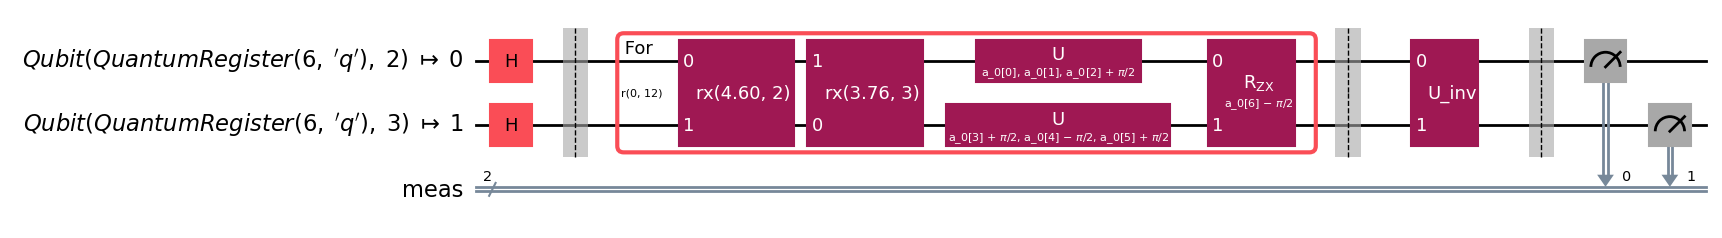

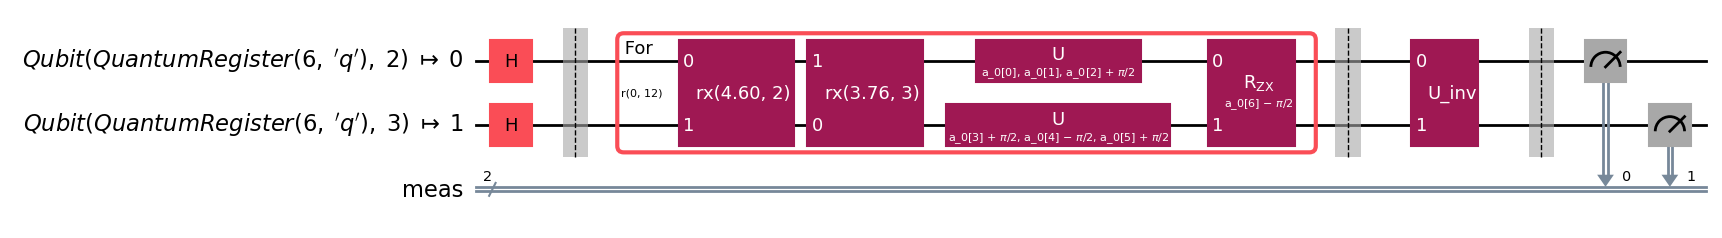

In [24]:
q_env.pubs[10].circuit.draw("mpl")

In [25]:
from qiskit.qasm3 import dumps as qasm3_dumps

print(
    qasm3_dumps(
        circuit_context(num_qubits, rotation_axes, rotation_parameters, coupling_map=cm)
    )
)

OPENQASM 3.0;
include "stdgates.inc";
input float[64] _θ_0_;
input float[64] _θ_1_;
input float[64] _θ_2_;
input float[64] _θ_3_;
input float[64] _θ_4_;
input float[64] _θ_5_;
qubit[6] q;
rx(_θ_0_) q[0];
rx(_θ_1_) q[1];
rx(_θ_2_) q[2];
rx(_θ_3_) q[3];
rx(_θ_4_) q[4];
rx(_θ_5_) q[5];
cx q[0], q[1];
cx q[2], q[3];
cx q[4], q[5];



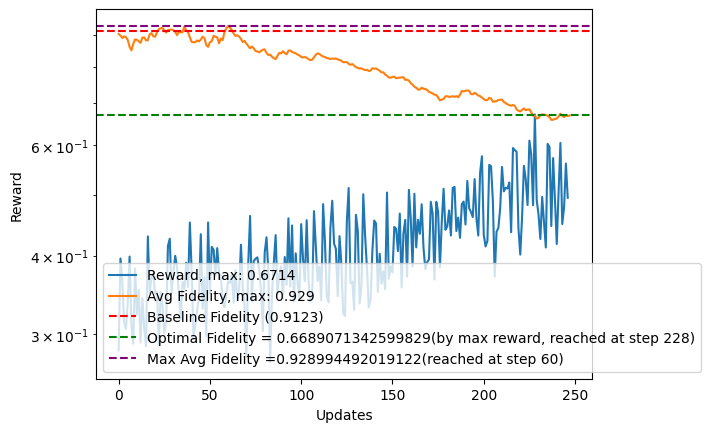

In [27]:
# Plotting the learning curve
import matplotlib.pyplot as plt

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = np.round(np.max(mean_rewards), 4)
arg_max_mean = np.argmax(mean_rewards)
baseline_fidelity = np.round(
    q_env.simulate_circuit(
        q_env.circuits[0],
        np.zeros((1, q_env.action_space.shape[-1])),
        update_env_history=False,
    ),
    4,
)[0]

plot_reward = True
plot_fidelity = True
plot_circuit_fidelity = False
plot_fidelity_nreps = False
plot_circuit_fidelity_nreps = False

if plot_reward:
    plt.plot(mean_rewards, label=f"Reward, max: {max_mean}")
if plot_fidelity:
    plt.plot(
        q_env.fidelity_history,
        label=f"Avg Fidelity, max: {np.round(np.max(q_env.fidelity_history),4)}",
    )
if plot_circuit_fidelity_nreps:
    plt.plot(
        q_env.circuit_fidelity_history_nreps,
        label=f"Circuit Fidelity nreps(={q_env.n_reps})",
    )
if plot_fidelity_nreps:
    plt.plot(
        q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})"
    )
if plot_circuit_fidelity:
    plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    baseline_fidelity,
    label=f"Baseline Fidelity ({baseline_fidelity})",
    color="red",
    linestyle="--",
)
plt.axhline(
    q_env.simulate_circuit(
        q_env.circuits[0], np.array([q_env.optimal_action]), update_env_history=False
    ),
    label=f"Optimal Fidelity = {q_env.fidelity_history[arg_max_mean]}(by max reward, reached at step {arg_max_mean})",
    color="green",
    linestyle="--",
)
plt.axhline(
    np.max(q_env.fidelity_history),
    label=f"Max Avg Fidelity ={np.max(q_env.fidelity_history)}(reached at step {np.argmax(q_env.fidelity_history)})",
    color="purple",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
# plt.title(
#     f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
#     f" backend: {q_env.config.backend.name if q_env.config.backend is not None else 'No backend'}"
# )
# plt.ylim(0.99, 1.00001)
plt.yscale("log")
plt.legend()

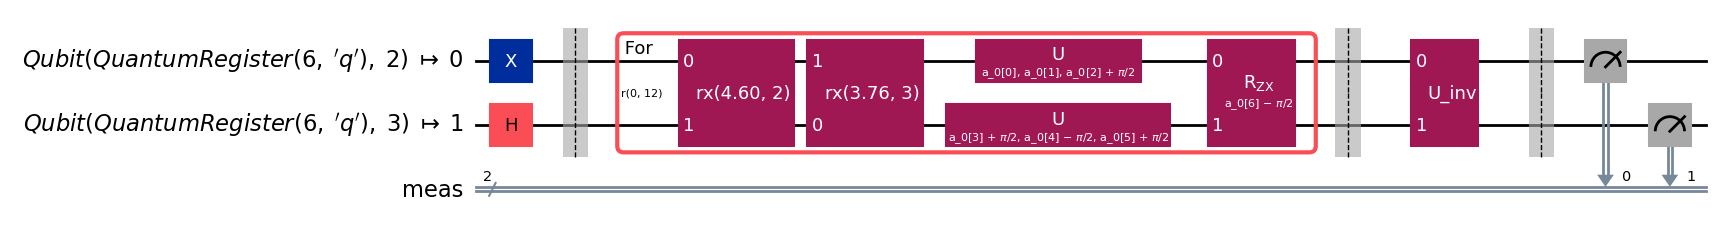

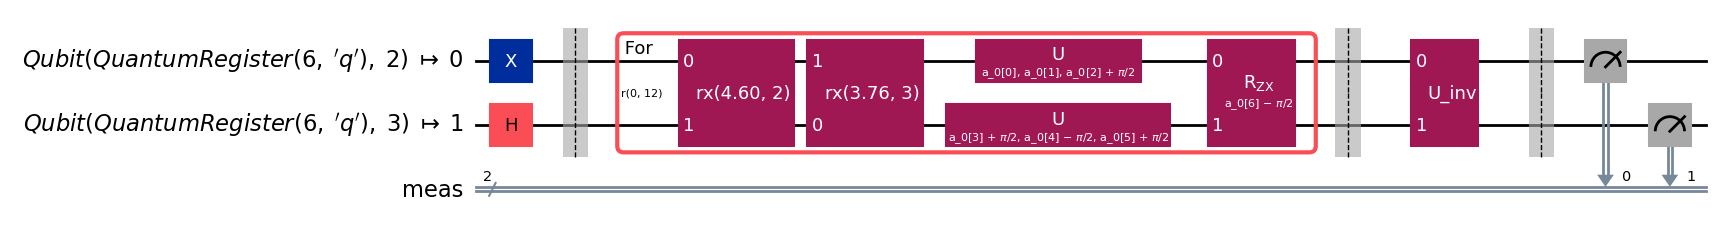

In [28]:
from qiskit.qasm3 import dumps as qasm3_dumps

circuit = q_env.pubs[6].circuit
circuit.draw("mpl")

In [29]:
print(qasm3_dumps(circuit))

TypeError: only length-1 arrays can be converted to Python scalars

In [30]:
q_env._pauli_shots

In [31]:
len(np.nonzero(np.round(q_env.target.Chi, 5))[0])

TypeError: unsupported operand type(s) for *: 'method' and 'float'

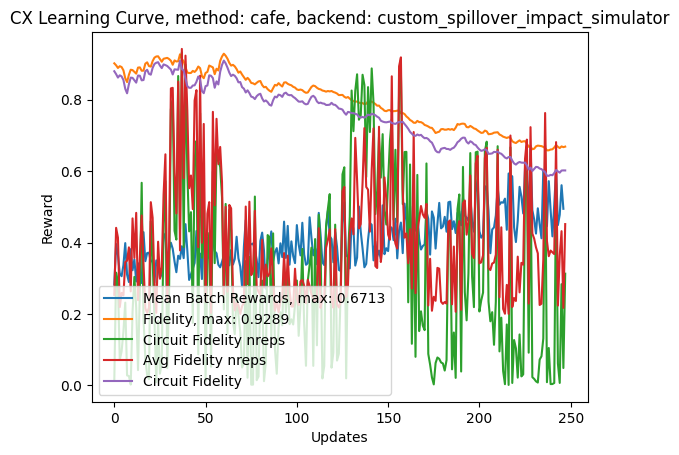

In [32]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [33]:
q_env.optimal_action

array([-0.812876  , -0.27809754,  0.7574113 ,  0.8680959 ,  0.03430464,
       -0.18851218, -0.9593679 ], dtype=float32)

In [34]:
q_env.optimal_action

array([-0.812876  , -0.27809754,  0.7574113 ,  0.8680959 ,  0.03430464,
       -0.18851218, -0.9593679 ], dtype=float32)

In [35]:
q_env.backend.operation_names

['measure',
 'roerror',
 'while_loop',
 'save_matrix_product_state',
 'for_loop',
 'save_amplitudes_sq',
 'ry',
 'break_loop',
 'save_probabilities_dict',
 's',
 'save_stabilizer',
 'save_amplitudes',
 'kraus',
 'save_statevector',
 'z',
 'save_unitary',
 'initialize',
 'save_density_matrix',
 'h',
 'unitary',
 'reset',
 'switch_case',
 'set_stabilizer',
 'u',
 'set_unitary',
 'save_state',
 'save_clifford',
 'quantum_channel',
 'continue_loop',
 'set_statevector',
 'superop',
 'save_expval_var',
 'set_matrix_product_state',
 'save_superop',
 'set_density_matrix',
 'set_superop',
 'save_statevector_dict',
 'cx',
 'qerror_loc',
 'rz',
 'save_expval',
 'save_probabilities',
 'delay',
 'rzx',
 'if_else',
 'rx',
 'x']